legi: 16-352-137

# SLT-CE-3: Histogram Clustering

In this coding exercise you will apply histogram clustering (HC) in order to segment an image. You will implement two different methods (maximum a posterior (MAP) and deterministic annealing (DA)) in order to predict the clusters membership for each pixel.

<h2 style="background-color:#f0b375;"> References </h2>

[1] Histogram clustering for unsupervised image segmentation: http://ieeexplore.ieee.org/document/784981/ 

[2] Lecture Slides 5: https://ml2.inf.ethz.ch/courses/slt/lectures/slt20_lecture05.pdf

[3] Lecture script: https://ml2.inf.ethz.ch/courses/slt/tutorials/SLT_Script.pdf chapter 2.7

<h2 style="background-color:#f0b375;"> Setup </h2>

In [142]:
import scipy
import sklearn as skl
import matplotlib.pyplot as plt
import numpy as np
import time
import math

from sklearn.utils.validation import check_is_fitted
from matplotlib.image import imread

from skimage.filters import gabor_kernel
print(np.__version__)

1.15.2


## Texture and corresponding label map
(This texture is used to fit your model.)

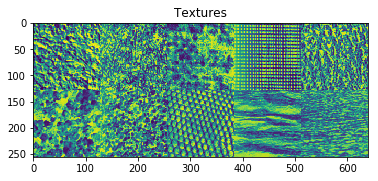

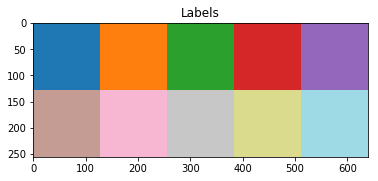

In [2]:
texture = imread("texture.png")

patch_grid_shape = (2,5)
patch_shape = (128,128)
label_map = np.ones(texture.shape)
for patch in range(np.prod(patch_grid_shape)):
    i, j = np.unravel_index(patch, patch_grid_shape)
    label_map[patch_shape[0] * i : patch_shape[0] * (i + 1), \
              patch_shape[1] * j : patch_shape[1] * (j + 1)] = np.ravel_multi_index((i,j), patch_grid_shape)

plt.imshow(texture)
plt.title("Textures")
plt.figure()
plt.imshow(label_map, cmap="tab20")
plt.title("Labels")
plt.show()

## Permuted texture and label map
(The permuted texture is used for the prediction)

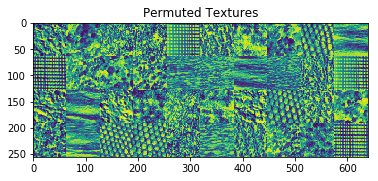

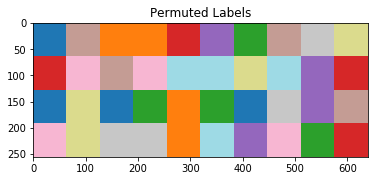

In [3]:
perm_patch_grid_shape = tuple(i * 2 for i in patch_grid_shape)
perm_patch_shape = tuple(i//2 for i in patch_shape)
n_perm_patches = np.prod(patch_grid_shape) * 4

np.random.seed(5)
perm = np.random.permutation(n_perm_patches)

perm_texture = np.ones(texture.shape)
perm_label_map = np.ones(texture.shape)

for patch, perm_patch in enumerate(perm):
    i, j = np.unravel_index(patch, perm_patch_grid_shape)
    ip, jp = np.unravel_index(perm_patch, perm_patch_grid_shape)
    
    perm_texture[ip * perm_patch_shape[0] : (ip + 1) * perm_patch_shape[0], \
                 jp * perm_patch_shape[1] : (jp + 1) * perm_patch_shape[1]] = \
    texture[i * perm_patch_shape[0] : (i + 1) * perm_patch_shape[0], \
            j * perm_patch_shape[1] : (j + 1) * perm_patch_shape[1]]
    
    perm_label_map[ip * perm_patch_shape[0] : (ip + 1) * perm_patch_shape[0], \
                   jp * perm_patch_shape[1] : (jp + 1) * perm_patch_shape[1]] = \
    label_map[i * perm_patch_shape[0] : (i + 1) * perm_patch_shape[0], \
              j * perm_patch_shape[1] : (j + 1) * perm_patch_shape[1]]
    
plt.imshow(perm_texture)
plt.title("Permuted Textures")
plt.figure()
plt.imshow(perm_label_map, cmap="tab20")
plt.title("Permuted Labels")
plt.show()

<h2 style="background-color:#f0b375;">
Section 4.0 
<span style=font-size:50%> Complete all problems in this section to get a pass on this exercise. </span>
</h2>

<p style="background-color:#adebad;">
    Read the references and recapitulate the parameter estimation formulas for both, Maximum a Posteriori estimation and Deterministic Annealing (DA) estimation. In particular, write down how equation (5) in reference [1] looks for the case of DA (using the notation of reference [1]). Hint: try to reformulate $\hat P(y|c)$ in terms of $\hat P(c|x)$ and use the maximum entropy principle to find an expression for $\hat P(c|x)$.
</p>

In case of MAP:

$\hat{P}(x) = \frac{n(x)}{\sum_{x'\in \mathbb{X}} n(x')}, \; \hat{P}(y|x) = \frac{n(x, y)}{n(x)}$

$\hat{P}(y|c) = \sum_{x: \hat{c}(x)=c}\frac{n(x)}{\sum_{x':\hat{c}(x')=c} n(x')}\hat{P}(y|x)$

$\hat{c}(x)=arg\min_a\{-\sum_{y\in\mathbb{Y}\hat{P}(y|x}\log\hat{P}(y|a)-\log P(\hat{c}_a^x)\}$

In the case of DA, equation (5) becomes $\hat{P}(y|c)=\frac{\sum_i P(c|x)\hat{P}(y|x)}{\sum_i P(c|x)}$, where $P(c|x)=\frac{\exp(-h(a,x;\hat{\theta})/T)}{\sum_{b=1}^K \exp(-h(b,x;\hat{\theta})/T)}$, $h(a,x;\hat{\theta})=n(x)D_{\text{KL}}[\hat{P}(\cdot|x)||\hat{P}(\cdot|a)]$ (derivation analogously to the task 3 from the Exercise 6, where words $w$ become $x$, verbs $b$ become features $y$ and clusters are denoted as $c$ instead of $k$)

[[1 1]]
[1 1]
5
30


In [10]:
np.shape(texture)[0]
print(texture)

[[0.11372549 0.3019608  0.6745098  ... 0.25490198 0.21568628 0.49803922]
 [0.11764706 0.03137255 0.14901961 ... 0.13333334 0.05882353 0.19607843]
 [0.3019608  0.05882353 0.04313726 ... 0.05490196 0.09803922 0.23921569]
 ...
 [0.3647059  0.5176471  0.8235294  ... 0.44313726 0.38039216 0.32156864]
 [0.05098039 0.22352941 0.6627451  ... 0.23137255 0.28235295 0.18431373]
 [0.10196079 0.13333334 0.2627451  ... 0.28235295 0.38039216 0.57254905]]


In [247]:
class HistogramClustering(skl.base.BaseEstimator, skl.base.TransformerMixin):
    """Template class for HistogramClustering (HC)
    
    Attributes:
        centroids (np.ndarray): Array of centroid distributions p(y|c) with shape (n_clusters, n_bins).
        
    Parameters:
        n_clusters (int): Number of clusters (textures).
        n_bins (int): Number of bins used to discretize the range of pixel values found in input image X.
        window_size (int): Size of the window used to compute the local histograms for each pixel.
                           Should be an odd number larger or equal to 3.
        random_state (int): Random seed.
        estimation (str): Whether to use Maximum a Posteriori ("MAP") or
                          Deterministic Annealing ("DA") estimation.
    """
    
    def __init__(self, n_clusters=10, n_bins=64, window_size=7, random_state=42, estimation="MAP"):
        self.n_clusters = n_clusters
        self.n_bins =n_bins
        self.window_size = window_size
        self.random_state = random_state
        self.estimation = estimation
        # Add more parameters, if necessary.
        self.centroids = np.empty((self.n_clusters, self.n_bins))
        for i in range(self.n_clusters):
            self.centroids[i, :] = np.random.random((self.n_bins))
            self.centroids[i, :] /= np.sum(self.centroids[i, :])

    def create_kernels(self): # Used code from https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_gabor.html
        # Function isn't used
        # prepare filter bank kernels
        kernels = []
        for theta in range(4):
            theta = theta / 4. * np.pi
            for sigma in (1, 3):
                for frequency in (0.05, 0.25):
                    kernel = np.real(gabor_kernel(frequency, theta=theta,
                                                  sigma_x=sigma, sigma_y=sigma,
                                                  n_stds=self.window_size/float(sigma)))
                    kernels.append(kernel)


    def create_hist(self, img):
        """Create histogram of pixels
        Returns histogram p(y|x) and sums n(x)
        """
        (h, w) = np.shape(img)
        hist = np.zeros((h, w, self.n_bins))
        n = np.empty_like(img)
        hist_all, bin_edges = np.histogram(img, self.n_bins)
        dif = (self.window_size - 1) / 2
        for i in range(h):
            for j in range(w):
                a = int(np.clip(i-dif, 0, h-1))
                b = int(np.clip(i+dif, 0, h-1))
                c = int(np.clip(j-dif, 0, w-1))
                d = int(np.clip(j+dif, 0, w-1))
                hist[i, j, :] = np.histogram(img[a:(b+1),c:(d+1)], bin_edges, 
                                             density=False)[0]
                n[i, j] = (b - a + 1) * (d - c + 1)

        return hist, n

    def fit(self, X):
        """Compute HC for input image X
        
        Compute centroids.        
        
        Args:
            X (np.ndarray): Input array with shape (height, width)
        
        Returns:
            self
        """
        
        if self.estimation == "MAP":
            # Code for Maximum a Posteriori estimation
            t1 = time.time()
            hist, n = self.create_hist(X)
            #hist, n = hist, n
            print(time.time()-t1)
            C = np.zeros(np.shape(X))
            loss = -100
            delta_loss = 100
            epsilon = 1e-3
            iteration = 0
            while (abs(loss) > epsilon) and (iteration < 50):
                
                # Maximization (6)
                res = []
                for a in range(0, self.n_clusters):
                    aux = np.zeros(np.shape(X))
                    for k in range(self.n_bins):
                        l = np.log(self.centroids[a,k])
                        if np.isfinite(l):
                             aux += l * hist[:,:,k] / n[:,:]
                    res.append(-aux)
                C = np.argmin(res, axis=0)
                #print(time.time() - t1)
                
                # Expectation (5)
                self.centroids = np.zeros((self.n_clusters, self.n_bins))
                for i in range(self.n_clusters):
                    indices = np.argwhere(C == i)
                    sum_n = 0
                    for ind in indices:
                        self.centroids[i, :] += hist[ind[0], ind[1]]
                        sum_n += n[ind[0], ind[1]]
                    self.centroids[i, :] /= sum_n
                print(time.time() - t1)

                # Loss calculation (3)
                loss_old = loss
                loss = 0
                #for i in range(np.shape(X)[0]):
                #   for j in range(np.shape(X)[1]):
                #print("check")
                #for i in range(self.n_clusters):
                #    print(np.sum(self.centroids, axis=1))
                for k in range(self.n_bins):
                    #c = C[i, j]
                    a = hist[:,:,c] * np.log(self.centroids[C[:,:],k])
                    #if (not math.isnan(a)):
                    #print("sum {}".format(np.sum(a[np.isfinite(a)])))
                    loss += np.sum(a[np.isfinite(a)]) #np.nansum(a)
                    delta_loss = loss - loss_old
                print('Iteration {}, loss {}'.format(iteration, loss))
                iteration += 1

        elif self.estimation == "DA":
            pass
            # Code for Deterministic Annealing estimation
        
        return self
    
    def predict(self, X):
        """Predict cluster assignments for each pixel in image X.
        
        Args:
            X (np.ndarray): Input array with shape (height, width)
            
        Returns:
            C (np.ndarray): Assignment map (height, width) 
        """
        check_is_fitted(self, ["centroids"])
        hist, n = self.create_hist(X)
        # Your code goes here
        res = []
        C = np.zeros(np.shape(X))
        for a in range(0, self.n_clusters):
            aux = np.zeros(np.shape(X))
            for k in range(self.n_bins):
                l = np.log(self.centroids[a,k])
                if np.isfinite(l):
                     aux += l * hist[:,:,k] / n[:,:]
            res.append(-aux)
        C = np.argmin(res, axis=0)
        
        return C
    
    def generate(self, C):
        """Generate a sample image X from a texture label map C.
        
        The entries of C are integers from the set {1,...,n_clusters}. They represent the texture labels
        of each pixel. Given the texture labels, a sample image X is generated by sampling
        the value of each pixel from the fitted p(y|c).
        
        Args:
            C (np.ndarray): Input array with shape (height, width)
            
        Returns:
            X (np.ndarray): Sample image (height, width)
        """
        check_is_fitted(self, ["centroids"])

        # Your code goes here
        X = 0
        return X
        

<p style="background-color:#adebad;">
Implement the "MAP" part of the <b>fit method</b> for the template class HistogramClustering, according to the contract outlined in its docstring. You can add more class methods if necessary. Create an instance of your HC class with n_clusters = 10 and fit the image texture. Record the execution time.
</p>

In [206]:
%%time
HC = HistogramClustering()
hist, n = HC.create_hist(texture)

CPU times: user 8.23 s, sys: 56 ms, total: 8.28 s
Wall time: 8.3 s


In [245]:
%%time
HC = HistogramClustering()
HC.fit(texture)
check_is_fitted(HC, ["centroids"])

8.472724676132202
10.91708493232727
Iteration 0, loss -9522862.256737547
13.713438272476196
Iteration 1, loss -9776610.867282089
16.33903169631958
Iteration 2, loss -10174619.700767979


/home/anton/anaconda3/envs/slt-ce/lib/python3.5/site-packages/ipykernel_launcher.py:122: RuntimeWarning: divide by zero encountered in log
/home/anton/anaconda3/envs/slt-ce/lib/python3.5/site-packages/ipykernel_launcher.py:122: RuntimeWarning: invalid value encountered in multiply
/home/anton/anaconda3/envs/slt-ce/lib/python3.5/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in log


18.816092252731323
Iteration 3, loss -10527009.973431103
21.251105308532715
Iteration 4, loss -10661814.842319505
23.64668107032776
Iteration 5, loss -10659706.877748726
26.092186450958252
Iteration 6, loss -10673835.69551531
28.64340877532959
Iteration 7, loss -10642952.076861264
31.08785080909729
Iteration 8, loss -10638016.943377575
33.730711221694946
Iteration 9, loss -10603383.150170507
36.65288162231445
Iteration 10, loss -10623674.374774583
39.19542980194092
Iteration 11, loss -10609095.721401457
41.78161358833313
Iteration 12, loss -10653883.880667794
44.12478566169739
Iteration 13, loss -10640727.37936347
46.528117656707764
Iteration 14, loss -10668173.728469396
48.896238565444946
Iteration 15, loss -10581903.72722831
51.25713348388672
Iteration 16, loss -10609910.171170997
53.60185527801514
Iteration 17, loss -10597862.111508716
56.000622510910034
Iteration 18, loss -10633533.133098952
58.48626208305359
Iteration 19, loss -10611524.292223452
60.90961194038391
Iteration 20, lo

<h2 style="background-color:#f0b375;">
Section 4.5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 4.5 </span>
</h2>

<p style="background-color:#adebad;">
    <ul style="background-color:#adebad;">
        <li> Implement the <b>predict method</b> for the template class HC, according to the contract outlined in its docstring.
        </li>        
        <li>
            Use HC.predict to predict the texture labels of perm_texture. Plot the predicted label map.
        </li>
    </ul>
</p>

In [246]:
%%time
predicted_perm_label_map = HC.predict(perm_texture)

-3.8785536628547757
-3.457743367974803
-11.424924507598313
-10.326312218930203
-2.843898401068751
-10.375102383099634
-9.681955202539688
-2.529705923832692
-8.964115409389372
-8.258846868297082
-3.669769332618455
-9.276490094431525
-3.344112289782869
-8.716874306496102
-2.8201129805719587
-8.436360723522935
-8.652335785358531
-3.4197004506501445
-3.8911544064735266
-3.9055420368485807
-4.030431400379275
-3.608737872309488
-8.940017857810313
-3.5292757007396642
-8.550553091048588
-3.59819638254249
-4.419265013634804
-4.01086811072163
-4.492755400527191
-4.090129022016879
-4.300676315277306
-4.250309588999807
-4.711621205216959
-4.698348580831353
-3.869766854039702
-4.760151122150049
-3.7883102311379404
-8.134392693823676
-3.8324143076188233
-4.9253523127913885
-4.3543217816576
-4.447909726011793
-4.20905447529282
-4.334371594688735
-4.72930219098178
-4.273998985474264
-4.444184335859687
-4.3279666386211915
-4.568161816340807
-4.266966529187959
-4.557247452183586
-4.055503837486506
-4.49

/home/anton/anaconda3/envs/slt-ce/lib/python3.5/site-packages/ipykernel_launcher.py:153: RuntimeWarning: divide by zero encountered in log


-3.6576099568204667
-8.095721790103847
-2.681919279029629
-8.88230297730989
-9.014362699322955
-2.9788531219648853
-4.686419625922128
-4.940420944469067
-3.9011000329695307
-3.6614457454966383
-4.559741842679286
-3.7112919421752113
-3.6951475729447227
-4.681155641015747
-3.8036558196763406
-4.597224461067862
-3.8736627992825343
-3.966016126322273
-3.9281471280903273
-4.369519413835935
-3.884046389739025
-4.589163892783866
-4.2174060861565215
-4.22442297490227
-4.384901703120533
-4.716197328245974
-6.354514600038623
-11.259789378477052
-inf
-9.864215571402
-8.78241040105027
-6.368213188021534
-5.219183851988777
-4.998349178047114
-4.649914072863794
-4.506136700514314
-4.443901835544711
-4.132007622562095
-4.311902190056989
-4.258413505106002
-3.758641394003943
-4.214126930943581
-3.992755275023111
-3.779033020420266
-4.092255372215688
-3.3992379354120064
-3.83244916502065
-4.3060370706045905
-3.598249180704666
-3.6153670898251073
-3.8168433923557217
-3.8584372896545585
-3.55175507281230

-9.972904778416462
-13.779567268186781
CPU times: user 11.8 s, sys: 132 ms, total: 11.9 s
Wall time: 10.1 s


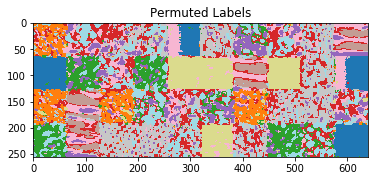

In [248]:
# Plot of predicted label map
plt.imshow(predicted_perm_label_map, cmap="tab20")
plt.title("Permuted Labels")
plt.show()

<p style="background-color:#adebad;">
    Plot a confusion matrix for your predictions, using the perm_label_map. Make sure to permute the texture labels appropriately, so that they are in correpondence with the true labels (see Hungarian algortihm to find the best match).
</p>

In [249]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

def plot_confusion(conf_matrix, title="Confusion matrix"):
    true = range(np.shape(conf_matrix)[0])
    predicted =  range(np.shape(conf_matrix)[0])

    fig, ax = plt.subplots()
    im = ax.imshow(conf_matrix)

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(true)))
    ax.set_yticks(np.arange(len(predicted)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(true)
    ax.set_yticklabels(predicted)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(true)):
        for j in range(len(predicted)):
            text = ax.text(j, i, conf_matrix[i, j],
                           ha="center", va="center", color="w")

    ax.set_title(title)
    fig.tight_layout()
    plt.show()

In [333]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment
def get_confusion_and_accuracy(perm_label_map, predicted_perm_label_map, 
                               n_clusters=10, n_bins=64):
    h = np.shape(predicted_perm_label_map)[0]
    w = np.shape(predicted_perm_label_map)[1]
    perm_label_map = perm_label_map.astype(int)
    err_matrix = np.zeros((n_clusters, n_clusters))
    count_1 = [np.count_nonzero(perm_label_map==i) for i in range(n_clusters)]
    count_2 = [np.count_nonzero(predicted_perm_label_map==i) for i in range(n_clusters)]
    err_matrix1 = -confusion_matrix(perm_label_map.flatten(), 
                                   predicted_perm_label_map.flatten())
    #plot_confusion(err_matrix1
    print(err_matrix1)
    print(np.matrix.trace(err_matrix1))
    
    for i in range(n_clusters):
        for j in range(n_clusters):
            err_matrix[i, j] = abs(count_1[i] - count_2[j]) 
    row_ind, col_ind = linear_sum_assignment(err_matrix1)
    print(err_matrix1[row_ind, col_ind])
    best_predicted_perm_label_map = np.zeros((h, w))
    # Replace predicted labels with new
    print(row_ind)
    print(col_ind)
    for i in range(h):
        for j in range(w):
            best_predicted_perm_label_map[i,j] = int(col_ind[perm_label_map[i,j]])
            #print(best_predicted_perm_label_map[i,j])
    conf_matrix = confusion_matrix(perm_label_map.flatten(), 
                                   best_predicted_perm_label_map.flatten())
    acc = 100*np.matrix.trace(conf_matrix)/np.sum(conf_matrix)
    print(np.matrix.trace(conf_matrix))
    return acc, conf_matrix

[[   -31 -10262   -211  -1932   -664    -59  -1138   -489   -782   -816]
 [    -2    -70   -175  -4412  -1873    -16  -2000  -4542   -108  -3186]
 [    -3    -97  -3115  -3078  -3450     -4  -1034   -608    -82  -4913]
 [-12943   -149   -191    -60    -71      0  -2625   -208    -56    -81]
 [     0    -69    -71  -3778   -697    -28   -496  -9326    -48  -1871]
 [   -20   -209   -198  -4909  -2556    -18  -3094  -1271   -117  -3992]
 [   -19   -106 -10542   -221  -1963    -61   -362   -189    -24  -2897]
 [     0   -105    -32  -2945   -563     -8   -998  -9854    -34  -1845]
 [   -24    -78    -58  -2881  -1573  -6190  -4718   -668    -38   -156]
 [     0      0    -17   -778    -24    -10   -913    -80 -14472    -90]]
-14335
[-10262  -1873  -4913 -12943  -3778  -3094 -10542  -9854  -6190 -14472]
[0 1 2 3 4 5 6 7 8 9]
[1 4 9 0 3 6 2 7 5 8]
16384
Accuracy=10.0%


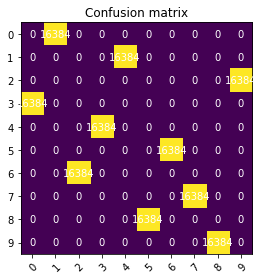

In [334]:
acc, conf_matrix =  get_confusion_and_accuracy(perm_label_map, predicted_perm_label_map, 
                               HC.n_clusters, HC.n_bins)
print("Accuracy={}%".format(acc))
plot_confusion(conf_matrix)

In [308]:
print(perm_label_map)

[[0. 0. 0. ... 8. 8. 8.]
 [0. 0. 0. ... 8. 8. 8.]
 [0. 0. 0. ... 8. 8. 8.]
 ...
 [6. 6. 6. ... 3. 3. 3.]
 [6. 6. 6. ... 3. 3. 3.]
 [6. 6. 6. ... 3. 3. 3.]]


<p style="background-color:#adebad;">
    Using n_clusters=10, fit HC with all combinations of n_bins = 16, 32, 64 and window_size = 7, 9, 11.
    For each setting compute the accuracy of the prediction on perm_texture. Show the results in a 3x3 matrix and label the axes properly.
</p>

In [234]:
# 3x3 Matrix with accuracy scores of the different parameter combination
n_clusters = 10
h = np.shape(texture)[0]
w = np.shape(texture)[1]
bins_list = (16, 32, 64)
windows_list =(7, 9, 11)

predicted_perm_label_map = np.zeros((len(bins_list), len(windows_list), h, w))
acc = np.zeros((len(bins_list), len(windows_list)))
               
for i, n_bins in enumerate(bins_list):
    for j, window_size in enumerate(windows_list):
        
        HC = HistogramClustering(n_clusters=n_clusters, n_bins=n_bins, 
                                 window_size=window_size)
        HC.fit(texture)
        predicted_perm_label_map[i, j, :, :] = HC.predict(perm_texture)
        acc[i, j], _ = get_confusion_and_accuracy(perm_label_map, predicted_perm_label_map[i, j, :, :], 
                               HC.n_clusters, HC.n_bins)

TypeError: fit() missing 2 required positional arguments: 'hist' and 'n'

In [ ]:
fig, ax = plt.subplots()
im = ax.imshow(acc)

# We want to show all ticks...
ax.set_xticks(np.arange(len(bins_list)))
ax.set_yticks(np.arange(len(windows_list)))
# ... and label them with the respective list entries
ax.set_xticklabels(true)
ax.set_yticklabels(predicted)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(bins_list)):
    for j in range(len(windows_list)):
        text = ax.text(j, i, acc[i, j],
                       ha="center", va="center", color="w")

ax.set_title("Confusion matrix")
fig.tight_layout()
plt.show()

<p style="background-color:#adebad;">
    For each setting plot the prediction (i.e. the clustering) of the texture (perm_texture) itself. Arrange the plots next to each other in a grid and label them properly.
    </p>

In [ ]:
# Cluster predictions (9 plots arranged in a 3x3 grid)

fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(x, y)
axs[0, 0].set_title('Axis [0, 0]')
axs[0, 1].plot(x, y, 'tab:orange')
axs[0, 1].set_title('Axis [0, 1]')
axs[1, 0].plot(x, -y, 'tab:green')
axs[1, 0].set_title('Axis [1, 0]')
axs[1, 1].plot(x, -y, 'tab:red')
axs[1, 1].set_title('Axis [1, 1]')

for ax in axs.flat:
    ax.set(xlabel='x-label', ylabel='y-label')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
plt.figure()
plt.imshow(perm_label_map, cmap="tab20")
plt.title("Permuted Labels")
plt.show()

<h2 style="background-color:#f0b375;">
Section 5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5 </span>
</h2>

<ul style="background-color:#adebad;">
        <li> Implement the <b>generate method</b> for the template class HC, according to the contract outlined in its docstring.
        </li>
        <li>
        Use HC.generate to generate ten 128x128 patches, one for each texture. Plot the generated textures next to the ground truth textures.
        </li>
    </ul>

In [ ]:
C1 = np.ones(patch_shape) * 0
X1 = HC.generate(C1)

# C2, C3, etc. You can also use a more suitable data structure to loop over the textures.

# Generated texture plot

<h2 style="background-color:#f0b375;">
Section 5.5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5.5 </span>
</h2>

<ul style="background-color:#adebad;">
    <li>
        Use k-means clustering to cluster the pixels of the texture (perm_texture). Set n_clusters=10, and use the local histogram vectors as features. Compare the predicted label map with k-means with the predicted label map obtained by HC.
    </li>
</ul>

In [33]:
# Predicted label map for k-means
from sklearn.cluster import KMeans
features, _ = HC.create_hist(texture)
features = np.reshape(features, (np.shape(features)[0]*np.shape(features)[1], 
                                 np.shape(features)[2]))
pred_kmeans = KMeans(n_clusters=10, random_state=42).fit_predict(features)
pred_kmeans = np.reshape(pred_kmeans, np.shape(texture))

In [ ]:
# Predicted label map for HC
HC = HistogramClustering()
HC.fit(texture)
pred_hc = HC.predict(perm_texture)

In [ ]:
plt.figure(1)
plt.imshow(pred_kmeans, cmap="tab20")
plt.title("K-means")
plt.figure(2)
plt.imshow(pred_kmeans, cmap="tab20")
plt.title("Histogram")
plt.show()

<ul style="background-color:#adebad;">
    <li>
        Moreover, plot and compare the confusion matrices for both, K-means, and HC.
    </li>
</ul>

In [ ]:
# Confusion matrices
acc_hc, conf_hc = get_confusion_and_accuracy(perm_label_map, predhc)
acc_kmeans, conf_kmeans = get_confusion_and_accuracy(perm_label_map, pred_kmeans)
print('Accuracies:\nHC: {}\nK-means: {}'.format(acc_hc, acc_kmeans))
plot_confusion(conf_hc, title="HC")
plot_confusion(conf_kmeans, title="K-means")

<ul style="background-color:#adebad;">
        <li>
Plot the centroid histograms $\hat P(y|c)$ after fitting the texture image, one centroid histogram for every texture image. Compare them to the empirical histograms (i.e. show them both in one plot).
        </li>
    </ul>

In [ ]:
# Histograms

plt.hist(HC.centroids[i,:])
emp_hist = np.zeros((n_clusters, n_bins))
for j in range(n_clusters)
    emp_hist[j] = perm_texture

In [ ]:
<h2 style="background-color:#f0b375;">
Section 6.0 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 6.0 </span>
</h2>

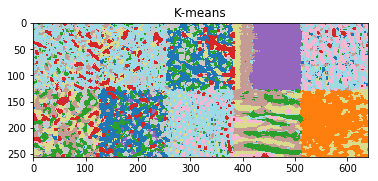

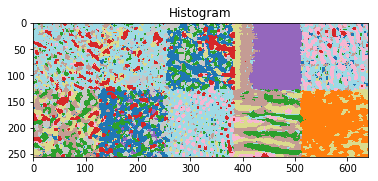

In [39]:
plt.figure(1)
plt.imshow(pred_kmeans, cmap="tab20")
plt.title("K-means")
plt.figure(2)
plt.imshow(pred_kmeans, cmap="tab20")
plt.title("Histogram")
plt.show()

<ul style="background-color:#adebad;">
    <li>
        Moreover, plot and compare the confusion matrices for both, K-means, and HC.
    </li>
</ul>

In [ ]:
# Confusion matrices
acc_hc, conf_hc = get_confusion_and_accuracy(perm_label_map, predhc)
acc_kmeans, conf_kmeans = get_confusion_and_accuracy(perm_label_map, pred_kmeans)
print('Accuracies:\nHC: {}\nK-means: {}'.format(acc_hc, acc_kmeans))
plot_confusion(conf_hc, title="HC")
plot_confusion(conf_kmeans, title="K-means")

<ul style="background-color:#adebad;">
        <li>
Plot the centroid histograms $\hat P(y|c)$ after fitting the texture image, one centroid histogram for every texture image. Compare them to the empirical histograms (i.e. show them both in one plot).
        </li>
    </ul>

In [ ]:
# Histograms

plt.hist(HC.centroids[i,:])
emp_hist = np.zeros((n_clusters, n_bins))
for j in range(n_clusters)
    emp_hist[j] = perm_texture

<h2 style="background-color:#f0b375;">
Section 6.0 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 6.0 </span>
</h2>

<ul style="background-color:#adebad;">
        <li>
        Implement the "DA" part of HC.fit.
        </li>
    </ul>

In [ ]:
%%time
HC = HistogramClustering(estimation="DA")
HC.fit(texture)
check_is_fitted(HC, ["centroids"])

<ul style="background-color:#adebad;">
        <li>
        Plot the clustering (predicted labels) of the texture (perm_texture) at different temperatures during the annealing schedule. What can you observe?
        </li>
    </ul>

In [ ]:
# Clustering at different temperatures

## Comments

We hope you found this exercise instructive.

Feel free to leave comments below, we will read them carefully.